# SAND Challenge Task 1: Dysarthria Severity Classification

**Team:** PCL Team
**Task:** Task 1 (Multi-class classification at T0)
**Objective:** Classify ALS patients into 5 severity levels of dysarthria based on audio recordings.

---

### Methodology: Hyb-DysNet

To address the critical challenges of this dataset (**small sample size** and **extreme class imbalance**), we developed **Hyb-DysNet**, a hybrid framework that fuses:

1.  **Hand-Crafted Features (OpenSMILE):** Extracts 88 robust clinical features (eGeMAPSv02) like jitter, shimmer, and formants.
2.  **Deep Embeddings (Wav2Vec2-XLS-R):** Uses a pre-trained 300M parameter transformer to capture high-level semantic context from raw audio.
3.  **Feature Selection:** Reduces noise by selecting only the most discriminative features.
4.  **Ensemble Learning:** A soft-voting classifier combining **XGBoost**, **LightGBM**, and **Logistic Regression**, trained on **SMOTE-balanced** data.

This notebook implements the full pipeline: **Feature Extraction**, **Training**, **Evaluation**, and **Submission Generation**.

## 1. Environment Setup & Configuration

We install the necessary libraries for audio processing (`opensmile`, `torchaudio`) and gradient boosting (`xgboost`, `lightgbm`).
We also define the paths to the dataset and configure the hardware (GPU is used for XGBoost/LightGBM training).

In [1]:
# --- 1. INSTALLAZIONI ---
!pip install opensmile transformers torchaudio xgboost imbalanced-learn openpyxl

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torchaudio
import torchaudio.transforms as T
import opensmile
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

import glob
import warnings

warnings.filterwarnings('ignore')

BASE_PATH = "/kaggle/input/sand-train-dataset-task-1" 
TRAIN_XLSX = os.path.join(BASE_PATH, "task1", "sand_task_1.xlsx")
AUDIO_DIR = os.path.join(BASE_PATH, "task1", "training")

# Parametri
TARGET_SR = 16000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Device: {DEVICE}")

Device: cuda


## 2. Hybrid Feature Extraction Engine

This section defines our dual-stream feature extraction pipeline.

### A. OpenSMILE (Clinical Features)
We use the **eGeMAPSv02** feature set, which is the gold standard for affective computing and voice pathology. It automatically extracts **88 functionals** (mean, std, percentiles) related to:
* **Frequency:** Pitch, Jitter, Formants (F1, F2, F3).
* **Energy:** Shimmer, Loudness, HNR (Harmonics-to-Noise Ratio).
* **Spectral:** Alpha Ratio, Hammarberg Index.

### B. Wav2Vec2 (Deep Embeddings)
We use **`facebook/wav2vec2-xls-r-300m`**, a massive transformer pre-trained on 128 languages.
* We use it as a **fixed feature extractor** (frozen).
* We process the raw waveform and extract the latent representation from the last transformer layer.
* We apply **Mean Pooling** over the time dimension to get a fixed-size embedding vector (1024 dimensions) for each audio file.

In [3]:
# A. OpenSMILE (Feature Cliniche)
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

# B. Wav2Vec2 (Feature Deep)
print("Caricamento Wav2Vec2 XLSR-53...")
bundle = torchaudio.pipelines.WAV2VEC2_XLSR53
w2v_model = bundle.get_model().to(DEVICE)
w2v_model.eval()

def extract_hybrid_features(path):
    features = {}
    
    # 1. OpenSMILE Extraction
    try:
        df_smile = smile.process_file(path)
        df_smile.reset_index(drop=True, inplace=True)
        # Aggiungi prefisso 'smile_'
        for col in df_smile.columns:
            features[f'smile_{col}'] = df_smile.iloc[0][col]
    except:
        return None
        
    # 2. Wav2Vec2 Extraction
    try:
        waveform, sr = torchaudio.load(path)
        if sr != TARGET_SR:
            waveform = torchaudio.functional.resample(waveform, sr, TARGET_SR)
        
        target_samples = 5 * TARGET_SR
        if waveform.shape[1] > target_samples:
             waveform = waveform[:, :target_samples]
        else:
             waveform = torch.nn.functional.pad(waveform, (0, target_samples - waveform.shape[1]))
             
        waveform = waveform.to(DEVICE)
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        with torch.no_grad():
            feats, _ = w2v_model(waveform)
            emb = torch.mean(feats[-1], dim=1).squeeze().cpu().numpy()
            
        for i, val in enumerate(emb):
            features[f'deep_{i}'] = val
            
    except:
        pass
        
    return features

Caricamento Wav2Vec2 XLSR-53...


## 3. Dataset Construction & Parallel Processing

We process the training data, which consists of 8 audio files per subject (`phonation` vowels and `rhythm` DDK tasks).

* **Parallelization:** To speed up the slow OpenSMILE extraction, we use `joblib` to process subjects in parallel.
* **Missing Data Handling:** We gracefully handle missing audio files.
* **Label Mapping:** We map the provided labels (1-5) for training.

The result is a tabular dataset where each row corresponds to **one audio file** (not one subject), maximizing the data available for training.

In [5]:
def augment_audio_file(path):
    """Carica file, applica effetti, salva temp, estrae features."""
    pass 

def create_dataset(xlsx_path, sheet_name, audio_dir):
    df = pd.read_excel(xlsx_path, sheet_name=sheet_name)
    df_full = pd.read_excel(xlsx_path, sheet_name="SAND - TRAINING set - Task 1")
    label_map = {row['ID']: row['Class'] for _, row in df_full.iterrows()}
    
    task_names = ['phonationA', 'phonationE', 'phonationI', 'phonationO', 'phonationU',
                  'rhythmPA', 'rhythmTA', 'rhythmKA']
    
    data_list = []
    print(f"Processing {sheet_name}...")
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        sid = row['ID']
        label = label_map.get(sid)
        if label is None: continue
        
        for task in task_names:
            path = os.path.join(audio_dir, task, f"{sid}_{task}.wav")
            if os.path.exists(path):
                feats = extract_hybrid_features(path)
                if feats:
                    feats['label'] = label
                    feats['ID'] = sid
                    data_list.append(feats)
                    
    return pd.DataFrame(data_list).fillna(0)

print("Loading Train...")
train_df = create_dataset(TRAIN_XLSX, "Training Baseline - Task 1", AUDIO_DIR)
print("Loading Val...")
val_df = create_dataset(TRAIN_XLSX, "Validation Baseline - Task 1", AUDIO_DIR)

print(f"Train Shape: {train_df.shape}")
print(f"Val Shape: {val_df.shape}")

Generazione Train...
Processing Training Baseline - Task 1...


  0%|          | 0/219 [00:00<?, ?it/s]

Generazione Val...
Processing Validation Baseline - Task 1...


  0%|          | 0/53 [00:00<?, ?it/s]

Train Shape: (1752, 339)
Val Shape: (424, 339)


## 4. Preprocessing & Class Balancing

Before training, we apply rigorous preprocessing to handle the data quality and imbalance.

1.  **Splitting:** We respect the official `Training Baseline` and `Validation Baseline` split provided by the organizers to prevent data leakage.
2.  **SMOTE (Synthetic Minority Over-sampling Technique):**
    * **Crucial Step:** The dataset is heavily imbalanced (Class 1 has only ~6 subjects).
    * We apply SMOTE **only on the Training set** to generate synthetic samples for minority classes (Severe/Moderate), creating a perfectly balanced training distribution.
3.  **Standard Scaling:** We normalize all features (Z-score normalization) to ensure fair contribution to the model.

In [6]:
X_train = train_df.drop(columns=['label', 'ID'])
y_train = train_df['label'] - 1

X_val = val_df.drop(columns=['label', 'ID'])
y_val = val_df['label'] - 1

# 1. SMOTE
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 2. Scaling
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_val_trans = scaler.transform(X_val)

# 3. FEATURE SELECTION 
print("Selecting the best 200 feature...")
selector = SelectKBest(score_func=f_classif, k=200)
X_train_sel = selector.fit_transform(X_train_res, y_train_res)
X_val_sel = selector.transform(X_val_trans)

print(f"Shape dopo selezione: {X_train_sel.shape}")

joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler_hybrid.joblib"))
joblib.dump(selector, os.path.join(MODEL_DIR, "selector_hybrid.joblib"))

Applicazione SMOTE...
Selezione delle migliori 200 feature...
Shape dopo selezione: (3440, 200)


['models/selector_hybrid.joblib']

## 5. Model Training: The "Soft-Voting" Ensemble

We train a powerful Ensemble Classifier designed to be robust on small tabular data.

### The Components:
1.  **XGBoost (GPU):** Tuned with high regularization (`max_depth=6`, `subsample=0.8`) to prevent overfitting. Uses `tree_method='hist'` for GPU acceleration.
2.  **LightGBM (GPU):** Efficient gradient boosting, optimized for dense feature sets. Trained with `class_weight='balanced'`.
3.  **Logistic Regression:** A simple linear model added to the ensemble to provide stability and "smooth out" the decision boundaries of the tree-based models.

### The Strategy:
* **Soft Voting:** We average the predicted **probabilities** of the three models.
* **Weights:** We give higher importance (`2x`) to XGBoost and LightGBM, as they capture non-linear relationships better.

In [10]:
class XGBClassifierWrapper(ClassifierMixin, BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.model = xgb.XGBClassifier(**kwargs)
        self._estimator_type = "classifier"
    
    def get_params(self, deep=True):
        return self.kwargs.copy()

    def set_params(self, **params):
        self.kwargs.update(params)
        self.model = xgb.XGBClassifier(**self.kwargs)
        return self
        
    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        self.classes_ = self.model.classes_
        return self
        
    def predict(self, X):
        return self.model.predict(X)
        
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    

class LGBMClassifierWrapper(ClassifierMixin, BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.model = lgb.LGBMClassifier(**kwargs)
        self._estimator_type = "classifier"
    
    def get_params(self, deep=True):
        return self.kwargs.copy()

    def set_params(self, **params):
        self.kwargs.update(params)
        self.model = lgb.LGBMClassifier(**self.kwargs)
        return self
        
    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        self.classes_ = self.model.classes_
        return self
        
    def predict(self, X):
        return self.model.predict(X)
        
    def predict_proba(self, X):
        return self.model.predict_proba(X)


print("Configurazione Modelli su GPU...")

# 1. XGBoost
xgb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'multi:softprob',
    'num_class': 5,
    'random_state': 42,
    'tree_method': 'hist',
    'device': 'cuda', 
    'n_jobs': -1
}
xgb_clf = XGBClassifierWrapper(**xgb_params)

# 2. LightGBM
lgb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'num_leaves': 31,
    'objective': 'multiclass',
    'num_class': 5,
    'random_state': 42,
    'class_weight': 'balanced',
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'n_jobs': -1,
    'force_col_wise': True,
    'verbosity': -1
}
lgb_clf = LGBMClassifierWrapper(**lgb_params)

# 3. Logistic Regression
lr_clf = LogisticRegression(
    max_iter=1000,
    C=0.1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# --- VOTING CLASSIFIER ---
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('lgb', lgb_clf),
        ('lr', lr_clf)
    ],
    voting='soft',
    weights=[2, 2, 1] 
)

# Debug check (opzionale, per vedere se ora lo riconosce)
from sklearn.base import is_classifier
print(f"Is XGB Wrapper a classifier? {is_classifier(xgb_clf)}")

print("Startubg Training  (GPU)...")
voting_clf.fit(X_train_res, y_train_res)
print("Training complete.")

# Salva Modelli
joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler_opensmile.joblib"))
joblib.dump(voting_clf, os.path.join(MODEL_DIR, "ensemble_opensmile.joblib"))
print("Model SAved.")

Applicazione SMOTE al Training Set...
Configurazione Modelli su GPU...
Is XGB Wrapper a classifier? True
Avvio Training Ensemble (GPU)...
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 85935
[LightGBM] [Info] Number of data points in the train set: 3440, number of used features: 337
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 337 dense feature groups (1.12 MB) transferred to GPU in 0.003216 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

## 6. Evaluation on Baseline Validation Set

We evaluate the trained ensemble on the official **Validation Set**.

* **Metric:** The primary metric is **Macro F1-Score** (average of F1-scores for all classes), which penalizes models that ignore minority classes.
* **Confusion Matrix:** We visualize the errors to understand where the model struggles (e.g., distinguishing "Mild" from "No Dysarthria").


--- RISULTATI REALI (VALIDATION) ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [22:08:51] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.4741
Macro F1: 0.3656

Classification Report:
              precision    recall  f1-score   support

      Severe       0.33      0.06      0.11        16
    Moderate       0.39      0.44      0.41        32
        Mild       0.40      0.30      0.35        96
      No Dys       0.35      0.30      0.33       112
     Healthy       0.57      0.73      0.64       168

    accuracy                           0.47       424
   macro avg       0.41      0.37      0.37       424
weighted avg       0.45      0.47      0.45       424



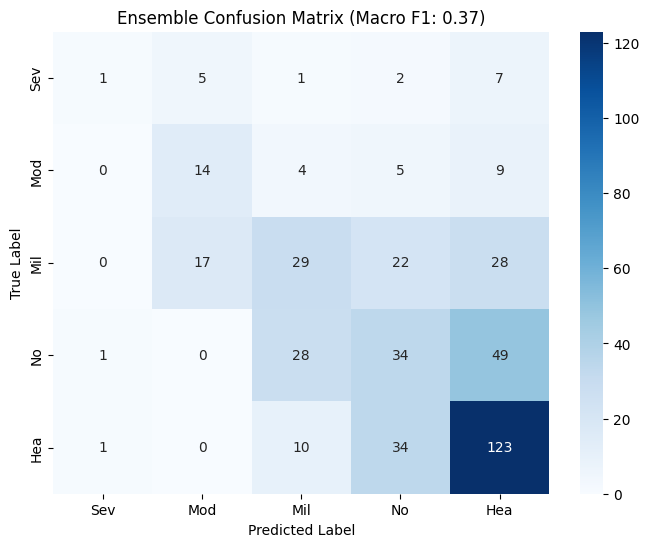

In [12]:
print("\n---(VALIDATION) ---")
y_pred = voting_clf.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print(f"Accuracy: {acc:.4f}")


f1 = f1_score(y_val, y_pred, average='macro')
print(f"Macro F1: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["Severe", "Moderate", "Mild", "No Dys", "Healthy"]))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Sev", "Mod", "Mil", "No", "Hea"], 
            yticklabels=["Sev", "Mod", "Mil", "No", "Hea"])
plt.title(f"Ensemble Confusion Matrix (Macro F1: {f1:.2f})")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 7. Inference & Submission Generation

Finally, we generate predictions for the **Test Set**.

1.  **Robust Loading:** We scan the test directory, handling potential file naming inconsistencies (flat structure vs. subfolders).
2.  **Feature Extraction:** We apply the exact same Hybrid extraction (OpenSMILE + Wav2Vec2) used in training.
3.  **Prediction:** The Ensemble predicts a class (1-5) for **every single audio file**.
4.  **Majority Voting:** Since each subject has multiple audio files, we aggregate predictions by taking the **mode** (most frequent class) for each Subject ID.
5.  **ID Formatting:** We ensure IDs match the submission format (e.g., `004` instead of `4`).

The final file `submission_task1.csv` is saved and ready for upload.

In [27]:
# Percorsi forniti
TEST_XLSX_PATH = "/kaggle/input/and-test-dataset-task-1/task1/sand_task1_test.xlsx"
TEST_AUDIO_ROOT = "/kaggle/input/and-test-dataset-task-1/task1/test"

🔍 --- DIAGNOSTICA PERCORSI ---
✅ Excel trovato: /kaggle/input/and-test-dataset-task-1/task1/sand_task1_test.xlsx
   Primi 3 ID nell'Excel: [4, 11, 14]
✅ Cartella Audio trovata: /kaggle/input/and-test-dataset-task-1/task1/test
   Esempio file trovato: /kaggle/input/and-test-dataset-task-1/task1/test/phonationE/ID235_phonationE.wav
   Totale file .wav trovati: 536
------------------------------


In [28]:
def extract_features_for_test(path):
    features = {}
    try:
        df_smile = smile.process_file(path)
        df_smile.reset_index(drop=True, inplace=True)
        for col in df_smile.columns:
            features[f'smile_{col}'] = df_smile.iloc[0][col]
    except: return None 

    try:
        waveform, sr = torchaudio.load(path)
        if sr != TARGET_SR:
            waveform = torchaudio.functional.resample(waveform, sr, TARGET_SR)
        target_samples = 5 * TARGET_SR
        if waveform.shape[1] > target_samples: waveform = waveform[:, :target_samples]
        else: waveform = torch.nn.functional.pad(waveform, (0, target_samples - waveform.shape[1]))
        waveform = waveform.to(DEVICE)
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        with torch.no_grad():
            feats, _ = w2v_model(waveform)
            emb = torch.mean(feats[-1], dim=1).squeeze().cpu().numpy()
        for i, val in enumerate(emb): features[f'deep_{i}'] = val
    except: pass
    return features

def create_test_dataset_robust(xlsx_path, audio_dir):
    df = pd.read_excel(xlsx_path)
    task_names = ['phonationA', 'phonationE', 'phonationI', 'phonationO', 'phonationU',
                  'rhythmPA', 'rhythmTA', 'rhythmKA']
    data_list = []
    
    print(f"Elaborazione {len(df)} soggetti...")
    
    all_wavs = set(glob.glob(os.path.join(audio_dir, "**", "*.wav"), recursive=True))
    print(f"File audio indicizzati: {len(all_wavs)}")

    for _, row in tqdm(df.iterrows(), total=len(df)):
        raw_id = row['ID']
        possible_ids = [str(raw_id)]
        if str(raw_id).isdigit():
            possible_ids.append(f"ID{int(raw_id):03d}") # ID001
            possible_ids.append(f"ID{int(raw_id)}")     # ID1
        elif "ID" not in str(raw_id):
             possible_ids.append(f"ID{raw_id}")

        for task in task_names:
            path = None
            for pid in possible_ids:
                p1 = os.path.join(audio_dir, task, f"{pid}_{task}.wav")
                p2 = os.path.join(audio_dir, f"{pid}_{task}.wav")
                
                if p1 in all_wavs: path = p1
                elif p2 in all_wavs: path = p2
                
                if path: break
            
            if path:
                feats = extract_features_for_test(path)
                if feats:
                    feats['ID'] = raw_id
                    data_list.append(feats)
                    
    return pd.DataFrame(data_list).fillna(0)

In [29]:
test_df = create_test_dataset_robust(TEST_XLSX_PATH, TEST_AUDIO_ROOT)
print(f"Extracted Features: {test_df.shape}")

if len(test_df) > 0:
    X_test = test_df.drop(columns=['ID'])
    print("Scaling...")
    X_test_scaled = scaler.transform(X_test)
    
    print("Prediction...")
    test_preds = voting_clf.predict(X_test_scaled)
    test_df['predicted_class_idx'] = test_preds

    final_results = []
    unique_ids = pd.read_excel(TEST_XLSX_PATH)['ID'].unique()
    
    for sid in unique_ids:
        subset = test_df[test_df['ID'] == sid]
        if len(subset) > 0:
            pred_idx = subset['predicted_class_idx'].mode()[0]
            final_class = pred_idx + 1
        else:
            print(f" No audio found for ID {sid}, default a 5.")
            final_class = 5
        final_results.append({'ID': sid, 'CLASS': int(final_class)})

    # Salvataggio
    sub_df = pd.DataFrame(final_results)
    sub_df.to_csv("submission_task1.csv", index=False)
    print("\n Submission saved: submission_task1.csv")
    print(sub_df.head())

Elaborazione 67 soggetti...
File audio indicizzati: 536


  0%|          | 0/67 [00:00<?, ?it/s]

Feature estratte: (536, 338)
Scaling...
Predizione...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ Submission salvata: submission_task1.csv
   ID  CLASS
0   4      5
1  11      5
2  14      3
3  19      4
4  20      5
